Please click File -> ***save a copy*** in your own drive, then play with the copy, instead of run this file.

# Part 0: Summary of Fraud Detection Code Lab
- Data is highly imbalanced
- Features of interval_after_signup and time related raw and aggregates are highly predictive of fraud
- Made actionable operation recommendations/proposal for business

# Part 1: Import Data

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -U imbalanced-learn
# !pip install pandas-profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 22.6 MB 22.9 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 85.1 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=352322 sha256=c61272c40099050879f5ea5d28bb5234da58ed7b782c8f0eaa110078b08f71f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-0pvui80w/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e85

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/fraudData"

imbalancedFraudDF.csv  IpAddress_to_Country.csv


In [ ]:
ipToCountry = pd.read_csv('drive/My Drive/fraudData/IpAddress_to_Country.csv')
fraud_data = pd.read_csv('drive/My Drive/fraudData/imbalancedFraudDF.csv')

fraud_data.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
3   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   
4   159135  2015-05-21 06:03:03  2015-07-09 08:05:14              42   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
3  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
4  ALEYXFXINSXLZ    Ads  Chrome   M   18  2.809315e+09      0

# Part 2: Data exploration

In [ ]:
#Distribution of the label column
fraud_data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [ ]:
!pip install --upgrade pip
!pip install --upgrade Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [ ]:
import pandas_profiling

#Inline summary report without saving report as object
pandas_profiling.ProfileReport(fraud_data)

#simpler version without installing pandas_profiling
# fraud_data.describe().transpose()

# will give warnings on missing, correlation, constant value(0 variance), etc, see http://nbviewer.jupyter.org/github/JosPolfliet/pandas-profiling/blob/master/examples/meteorites.ipynb


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Check Missing values

In [ ]:
# count of NaN in each column
fraud_data.isna().sum()
#fraud_data.isnull().sum(axis = 0)

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

### Identify country info based on ip_address


In [ ]:
ipToCountry.head()

lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China

In [ ]:
#start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']#number
    #check which interval does ip_address falls into
    #below [] is list of T/F, only when this ip_address falls into the correct internal row does the index generate a True
    #tmp is a df of shape n * 3, where n is 1 if found a match (ip_address falls in range) or 0 if no match
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('NA')

fraud_data['country'] = countries
#runtime = time.time() - start
#print("Lookup took", runtime, "seconds.")

In [ ]:
fraud_data.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
3   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   
4   159135  2015-05-21 06:03:03  2015-07-09 08:05:14              42   

       device_id source browser sex  age    ip_address  class        country  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States  
2  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0             NA  
3  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States  
4  ALEYXFXINSXLZ    Ads  Chrome   M   18  2.809315e+09      0         Canada

In [ ]:
print(fraud_data.user_id.nunique())#138376
print(len(fraud_data.index))#138376
#all of the user_id has only the first 1 transaction, no way to do time based aggregates,
#e.g. amount/counts in past 1 day for this user

138376
138376


### Feature Engineering

In [ ]:
#time related features: can be done before split, as they has no interaction between other rows, solely based on other columns of the same row
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(
        fraud_data['signup_time'])).dt.total_seconds()

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear

#bed time operation
fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(
      fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis=1)

In [ ]:
fraud_data.head()
#note there are NAs in country

purchase_value      device_id source browser sex  age    ip_address  class  \
0              34  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
1              16  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
2              44  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
3              39  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   
4              42  ALEYXFXINSXLZ    Ads  Chrome   M   18  2.809315e+09      0   

         country  interval_after_signup  signup_days_of_year  \
0          Japan              4506682.0                   55   
1  United States                17944.0                  158   
2             NA               492085.0                  118   
3  United States              4361461.0                  202   
4         Canada              4240931.0                  141   

   signup_seconds_of_day  purchase_days_of_year  purchase_seconds_of_day  
0                  82549                    108                    10031  
1                  74390                    159                     5934  
2                  76405                    124                    50090  
3                  25792                    252                    67253  
4                  21783                    190                    29114

In [ ]:
print(fraud_data.source.value_counts())

SEO       55766
Ads       54913
Direct    27697
Name: source, dtype: int64


### Train/Valid/Test Data Split

In [ ]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis=1)

#split into train/test
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
print("X_train.shape:", X_train.shape)
print("X_valid.shape:", X_valid.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
print("y_train.shape:", y_train.shape)
print("y_valid.shape:", y_valid.shape)

X_train.shape: (110700, 13)
X_valid.shape: (13838, 13)
X_test.shape: (13838, 13)
y_test.shape: (13838,)
y_train.shape: (110700,)
y_valid.shape: (13838,)


In [ ]:
X_train['country'].value_counts(ascending=True)
#drawback: collision in the same bucket(no differentiation for these countries)

Benin                 1
Yemen                 1
Fiji                  1
Monaco                1
Madagascar            1
                  ...  
United Kingdom     3253
Japan              5251
China              8876
NA                16275
United States     42348
Name: country, Length: 177, dtype: int64

In [ ]:
X_train.head()

purchase_value      device_id  source  browser sex  age    ip_address  \
29343              12  OULPAZAFRFPXP     Ads   Chrome   M   42  3.690922e+09   
12190              10  AIIWMFEYQQIEB     Ads    Opera   M   29  1.686759e+09   
19388              34  VUVETBUPCIWJE  Direct   Chrome   M   53  4.138429e+09   
89104              48  QCFULAJOYKFUU     Ads   Chrome   M   29  9.617337e+07   
82082              44  IHRWLMIJMEEEU     Ads  FireFox   M   24  1.936025e+09   

                 country  interval_after_signup  signup_days_of_year  \
29343  Korea Republic of              3499664.0                  183   
12190      United States              6766039.0                    5   
19388                 NA              5870515.0                  197   
89104             France              2145618.0                  160   
82082              China              7079059.0                  111   

       signup_seconds_of_day  purchase_days_of_year  purchase_seconds_of_day  
29343                  67384                    224                    24648  
12190                  78146                     84                    18585  
19388                  81354                    265                    76669  
89104                  30920                    185                    16538  
82082                  71897                    193                    66156

In [ ]:
fraud_purchase_total = fraud_data.loc[fraud_data['class'] == 1, 'purchase_value'].sum()
fraud_purchase_total

53579

### Feature Engineering


Convert categorical features with high cadinality to numericals

In [ ]:
#converting needs to be done after split
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])
X_train['sex'] = (X_train.sex == 'M').astype(int)

# the more a device is shared, the more suspicious
# if device_id abc occurred 100 times in X_train, then replace all abc in device_id col in X_train by 100
X_train_device_id_mapping = X_train.device_id.value_counts(dropna=False)
X_train['n_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping)# number of times device_id occurred in train data

# the more a ip is shared, the more suspicious
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna=False)
X_train['n_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

# the less visit from a country, the more suspicious
X_train_country_mapping = X_train.country.value_counts(dropna=False)#include counts of NaN
X_train['n_country_shared'] = X_train.country.map(X_train_country_mapping)#lots of NAs in country column, #without dropna=False will produce nan in this col


X_train = X_train.drop(['device_id','ip_address','country'], axis=1)


In [ ]:
############## Feature Engineering to avoid Data Leakage   ###############

X_valid = pd.get_dummies(X_valid, columns=['source', 'browser'])
X_valid['sex'] = (X_valid.sex == 'M').astype(int)


X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)


# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/target-encoding.html
# the more a device is shared, the more suspicious
# X_test['n_dev_shared'] = X_test.device_id.map(X_train_device_id_mapping)

# the more a ip is shared, the more suspicious
# X_test['n_ip_shared'] = X_test.ip_address.map(X_train_ip_address_mapping)

# the less visit from a country, the more suspicious
# X_test['n_country_shared'] = X_test.country.map(X_train_country_mapping)

#but here device_id, ip_address has few overlap between train and test, if we apply the above
# 3 X_train_mappings (generated from X_train) on X_test, then most of the X_test will be NaN, as we can not find the keys in the train mapping




# if apply train mapping, most of the levels in test does not occur in train, so most are null after converting, so redo mapping on test data, which we should not

# the more a device is shared, the more suspicious
X_valid['n_dev_shared'] = X_valid.device_id.map(X_valid.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_valid['n_ip_shared'] = X_valid.ip_address.map(X_valid.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_valid['n_country_shared'] = X_valid.country.map(X_valid.country.value_counts(dropna=False))

X_valid = X_valid.drop(['device_id','ip_address','country'], axis=1)


# the more a device is shared, the more suspicious
X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna=False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)

# if the levels/values/mapping keys of the column in train and test data are pretty much the same(lots of overlap), e.g. country,
# then we should apply the above 3 X_train_mappings (generated from X_train) on X_test(like below),
# rather than using the new mapping generated from X_test



In [ ]:
X_train.head()

purchase_value  sex  age  interval_after_signup  signup_days_of_year  \
29343              12    1   42              3499664.0                  183   
12190              10    1   29              6766039.0                    5   
19388              34    1   53              5870515.0                  197   
89104              48    1   29              2145618.0                  160   
82082              44    1   24              7079059.0                  111   

       signup_seconds_of_day  purchase_days_of_year  purchase_seconds_of_day  \
29343                  67384                    224                    24648   
12190                  78146                     84                    18585   
19388                  81354                    265                    76669   
89104                  30920                    185                    16538   
82082                  71897                    193                    66156   

       source_Ads  source_Direct  source_SEO  browser_Chrome  browser_FireFox  \
29343           1              0           0               1                0   
12190           1              0           0               0                0   
19388           0              1           0               1                0   
89104           1              0           0               1                0   
82082           1              0           0               0                1   

       browser_IE  browser_Opera  browser_Safari  n_dev_shared  n_ip_shared  \
29343           0              0               0             1            1   
12190           0              1               0             1            1   
19388           0              0               0             1            1   
89104           0              0               0             1            1   
82082           0              0               0             1            1   

       n_country_shared  
29343              3075  
12190             42348  
19388             16275  
89104              2322  
82082              8876

### Normalization vs Standardization

In [ ]:
# # normalize (min-max) to [0,1], standardize(StandardScaler) to normal, mu=0,var = 1 can < 0, so we do normalize here

# needs to be brought to the same scale for models like LR with regularization(that are not tree based)

#Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])
#print(scaler.data_max_)

#transform the training data and use them for the model training
X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above, on X_valid, not fitting a brandnew scaler on test
X_valid[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_valid[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above, on X_test, not fitting a brandnew scaler on test
X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])



In [ ]:
X_train.n_dev_shared.value_counts(dropna=False)

0.0    105427
0.2      4774
0.4       324
0.6       124
0.8        45
1.0         6
Name: n_dev_shared, dtype: int64

In [ ]:
X_valid.n_dev_shared.value_counts(dropna=False)

0.0    13739
0.2       96
0.4        3
Name: n_dev_shared, dtype: int64

In [ ]:
X_test.n_dev_shared.value_counts(dropna=False)

0.0    13764
0.2       74
Name: n_dev_shared, dtype: int64

# Part 5: Model Training


In [ ]:
def performance_metrics(confusion_matrix):
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1], "Confusion matrix should be square."

    num_classes = confusion_matrix.shape[0]

    true_positives = np.diag(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives
    true_negatives = np.sum(confusion_matrix) - (true_positives + false_positives + false_negatives)

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("precision:", precision[1])
    print("recall:", recall[1])
    print("f1", f1_score[1])
    print("specificity:", specificity[1])
    return precision, recall, specificity, f1_score

#### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
####xg_class = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#####              colsample_bynode=1, colsample_bytree=1, gamma=0,
#####              importance_type='gain', learning_rate=0.01, max_depth= 10,
#####              min_child_weight=1, n_estimators=100, n_jobs= 5, num_parallel_tree=1, random_state=0,
#####              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1)

In [ ]:
xg_class = xgb.XGBClassifier()
xg_class.fit(X_train,y_train)
xg_preds_train = xg_class.predict(X_train)
xg_preds_valid = xg_class.predict(X_valid)

In [ ]:
xg_cm_train = metrics.confusion_matrix(y_train, xg_preds_train)
xg_cmDF_train = pd.DataFrame(xg_cm_train, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(xg_cmDF_train)

        pred_0  pred_1
true_0  109572       0
true_1     439     689


In [ ]:
xg_cm_valid = metrics.confusion_matrix(y_valid, xg_preds_valid)
xg_cmDF_valid = pd.DataFrame(xg_cm_valid, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(xg_cmDF_valid)

        pred_0  pred_1
true_0   13694       0
true_1      74      70


In [ ]:
#@title Hide for later(XGBoost)
xg_preds_test = xg_class.predict(X_test)
xg_cm_test = metrics.confusion_matrix(y_test, xg_preds_test)
xg_cmDF_test = pd.DataFrame(xg_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(xg_cmDF_test)

        pred_0  pred_1
true_0   13695       0
true_1      68      75


In [ ]:
performance_metrics(xg_cm_test)

precision: 1.0
recall: 0.5244755244755245
f1 0.6880733944954128
specificity: 1.0


(array([0.99505922, 1.        ]),
 array([1.        , 0.52447552]),
 array([0.52447552, 1.        ]),
 array([0.99752349, 0.68807339]))

In [ ]:
accuracy_score(y_test, xg_preds_test)

0.995085995085995

In [ ]:
#### print the performance metrics ######
performance_metrics(xg_cm_train)

precision: 1.0
recall: 0.6108156028368794
f1 0.7583929554210237
specificity: 1.0


(array([0.99600949, 1.        ]),
 array([1.       , 0.6108156]),
 array([0.6108156, 1.       ]),
 array([0.99800076, 0.75839296]))

In [ ]:
performance_metrics(xg_cm_valid)

precision: 1.0
recall: 0.4861111111111111
f1 0.6542056074766355
specificity: 1.0


(array([0.99462522, 1.        ]),
 array([1.        , 0.48611111]),
 array([0.48611111, 1.        ]),
 array([0.99730537, 0.65420561]))

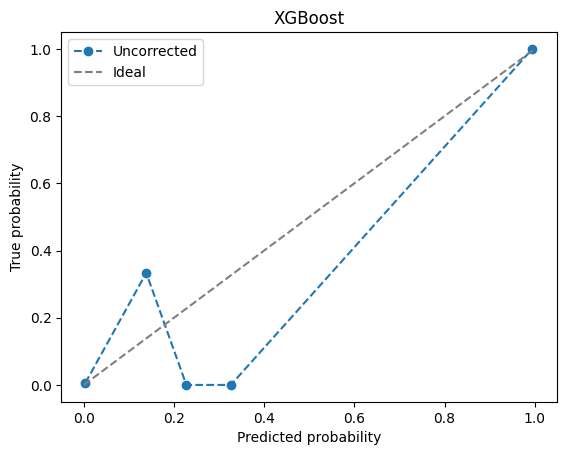

In [ ]:
from sklearn.calibration import calibration_curve

# Assuming you have a binary classification model with predicted probabilities called 'y_proba' and true labels called 'y_true'
y_true = y_valid
# Calculate calibration curve
xg_y_pred_proba = xg_class.predict_proba(X_valid)
xg_prob_true, xg_prob_pred = calibration_curve(y_true, xg_y_pred_proba[:, 1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(xg_prob_pred, xg_prob_true, marker='o', linestyle='--', label='Uncorrected')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color='gray')
ax.set_title('XGBoost')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, model_name, title=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    if title:
        plt.title(f"{model_name} - {title} ROC Curve")
    else:
        plt.title(f"{model_name} ROC Curve")

    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

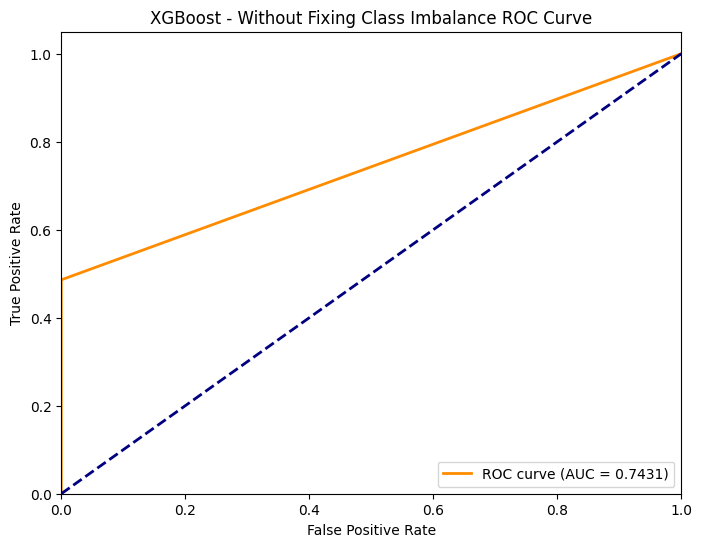

AUC: 0.7430555555555556


In [ ]:
y_pred_prob_xg = xg_preds_valid
xg_roc_auc = plot_roc_curve(y_true, y_pred_prob_xg, "XGBoost", title = "Without Fixing Class Imbalance")
print("AUC:", xg_roc_auc)

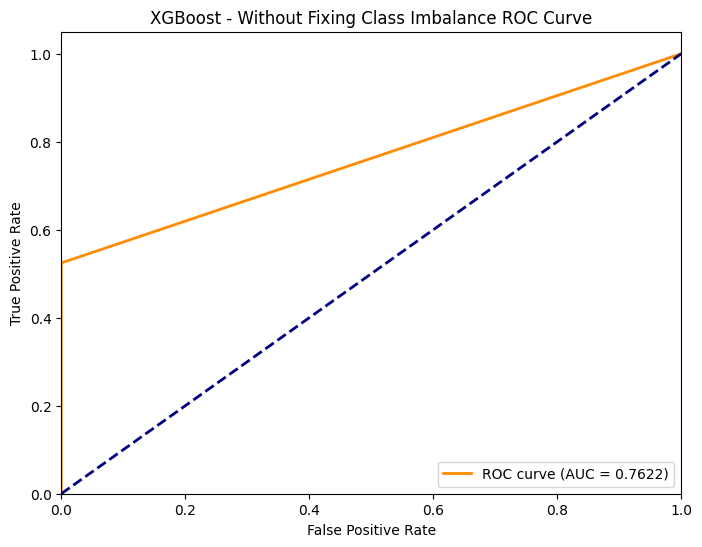

0.7622377622377623

In [ ]:
plot_roc_curve(y_test, xg_preds_test, "XGBoost", title = "Without Fixing Class Imbalance")

Simple KNN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knnModel = KNeighborsClassifier()
knnModel.fit(X_train, y_train)
knn_y_pred_train = knnModel.predict(X_train)
knn_y_pred_valid = knnModel.predict(X_valid)

In [ ]:
knn_cm_train = metrics.confusion_matrix(y_train, knn_y_pred_train)
knn_cmDF_train = pd.DataFrame(knn_cm_train, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(knn_cmDF_train)

        pred_0  pred_1
true_0  109552      20
true_1     534     594


In [ ]:
knn_cm_valid = metrics.confusion_matrix(y_valid, knn_y_pred_valid)
knn_cmDF_valid = pd.DataFrame(knn_cm_valid, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(knn_cmDF_valid)

        pred_0  pred_1
true_0   13691       3
true_1      74      70


In [ ]:
#@title Hide for later(kNN)
knn_y_pred_test = knnModel.predict(X_test)
knn_cm_test = metrics.confusion_matrix(y_test, knn_y_pred_test)
knn_cmDF_test = pd.DataFrame(knn_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(knn_cmDF_test)

        pred_0  pred_1
true_0   12501    1194
true_1      62      81


In [ ]:
performance_metrics(knn_cm_test)

precision: 0.06352941176470588
recall: 0.5664335664335665
f1 0.11424541607898447
specificity: 0.912814895947426


(array([0.99506487, 0.06352941]),
 array([0.9128149 , 0.56643357]),
 array([0.56643357, 0.9128149 ]),
 array([0.95216696, 0.11424542]))

In [ ]:
performance_metrics(knn_cm_train)

precision: 0.9674267100977199
recall: 0.526595744680851
f1 0.6819747416762342
specificity: 0.9998174716168364


(array([0.99514925, 0.96742671]),
 array([0.99981747, 0.52659574]),
 array([0.52659574, 0.99981747]),
 array([0.9974779 , 0.68197474]))

In [ ]:
performance_metrics(knn_cm_valid)

precision: 0.958904109589041
recall: 0.4861111111111111
f1 0.6451612903225806
specificity: 0.9997809259529721


(array([0.99462405, 0.95890411]),
 array([0.99978093, 0.48611111]),
 array([0.48611111, 0.99978093]),
 array([0.99719582, 0.64516129]))

#### Calibration Curve and its intercept

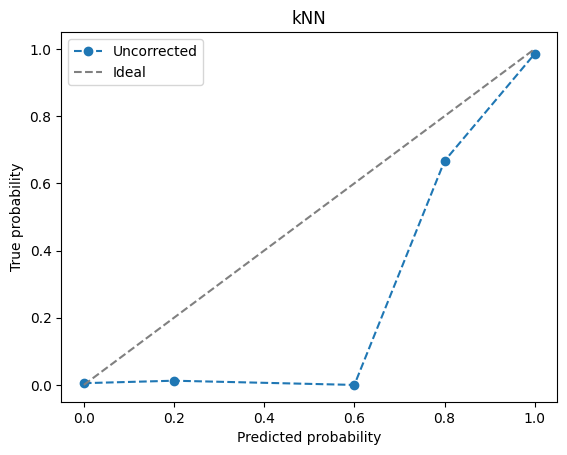

In [ ]:
y_true = y_valid
knn_y_pred_proba = knnModel.predict_proba(X_valid)
knn_prob_true, knn_prob_pred = calibration_curve(y_true, knn_y_pred_proba[:, 1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(knn_prob_pred, knn_prob_true, marker='o', linestyle='--', label='Uncorrected')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color='gray')
ax.set_title('kNN')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

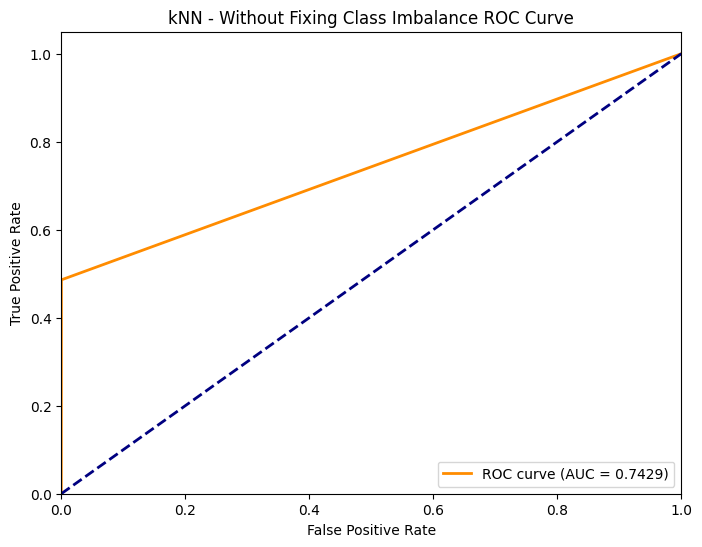

AUC: 0.7429460185320417


In [ ]:
y_pred_prob_knn = knn_y_pred_valid
knn_roc_auc = plot_roc_curve(y_true, y_pred_prob_knn, "kNN", title = "Without Fixing Class Imbalance")
print("AUC:", knn_roc_auc)

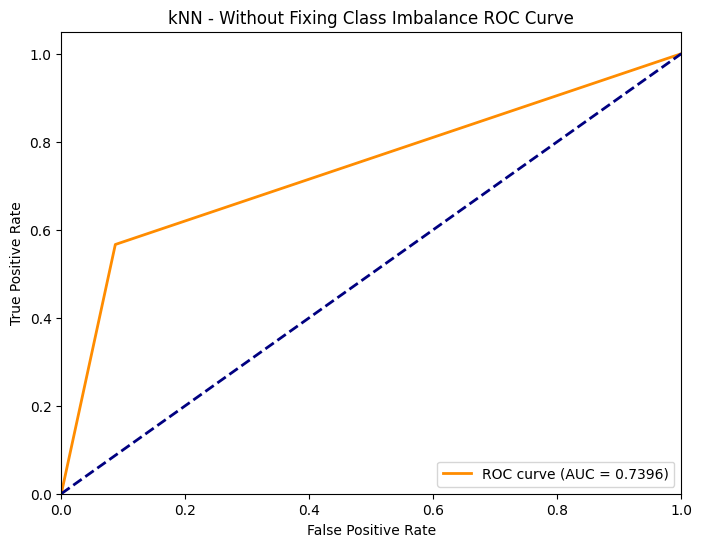

0.7396242311904963

In [ ]:
plot_roc_curve(y_test, knn_y_pred_test, "kNN", title = "Without Fixing Class Imbalance")

Simple LogisticRegression model

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# predict on test
logreg_y_pred_train = logreg.predict(X_train)
logreg_y_pred_valid = logreg.predict(X_valid)
logreg_y_proba_valid = logreg.predict_proba(X_valid)

In [ ]:
logreg_cm_train = metrics.confusion_matrix(y_train, logreg_y_pred_train)
logreg_cmDF_train = pd.DataFrame(logreg_cm_train, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logreg_cmDF_train)

        pred_0  pred_1
true_0  109572       0
true_1    1128       0


In [ ]:
logreg_cm_valid = metrics.confusion_matrix(y_valid, logreg_y_pred_valid)
logreg_cmDF_valid = pd.DataFrame(logreg_cm_valid, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logreg_cmDF_valid)

        pred_0  pred_1
true_0   13694       0
true_1     144       0


In [ ]:
logreg_y_pred_test = logreg.predict(X_test)
logreg_cm_test= metrics.confusion_matrix(y_test, logreg_y_pred_test)
logreg_cmDF_test = pd.DataFrame(logreg_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logreg_cmDF_test)

        pred_0  pred_1
true_0   13695       0
true_1     143       0


In [ ]:
performance_metrics(logreg_cm_train)

precision: nan
recall: 0.0
f1 nan
specificity: 1.0


(array([0.9898103,       nan]),
 array([1., 0.]),
 array([0., 1.]),
 array([0.99487906,        nan]))

In [ ]:
performance_metrics(logreg_cm_valid)

precision: nan
recall: 0.0
f1 nan
specificity: 1.0


(array([0.98959387,        nan]),
 array([1., 0.]),
 array([0., 1.]),
 array([0.99476972,        nan]))

In [ ]:
performance_metrics(logreg_cm_test)

precision: nan
recall: 0.0
f1 nan
specificity: 1.0


(array([0.98966614,        nan]),
 array([1., 0.]),
 array([0., 1.]),
 array([0.99480623,        nan]))

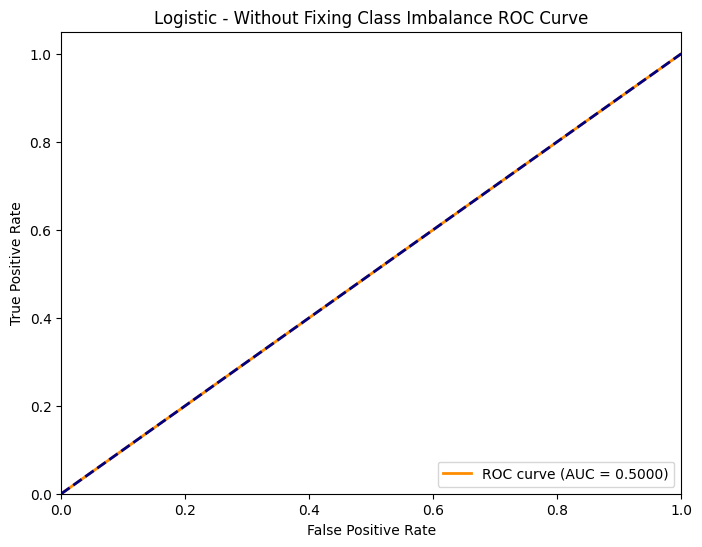

AUC: 0.5


In [ ]:
y_true = y_valid
y_pred_prob_logreg = logreg_y_pred_valid
logreg_roc_auc = plot_roc_curve(y_true, y_pred_prob_logreg, "Logistic", title = "Without Fixing Class Imbalance")
print("AUC:", logreg_roc_auc)

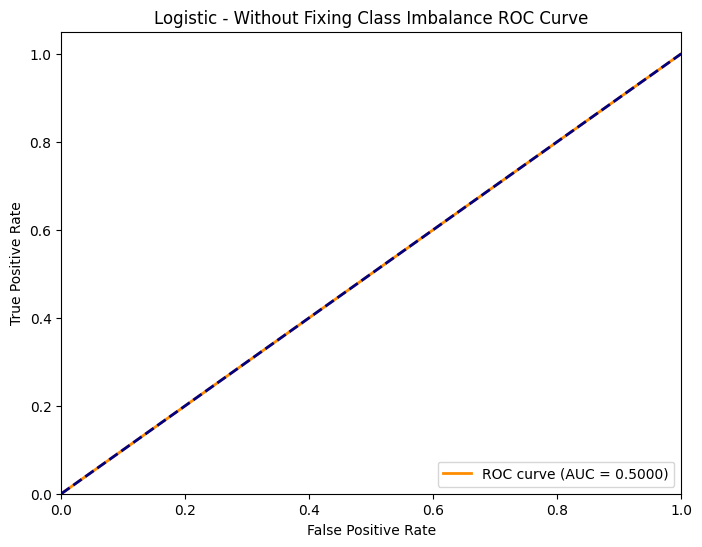

0.5

In [ ]:
plot_roc_curve(y_test, logreg_y_pred_test , "Logistic", title = "Without Fixing Class Imbalance")

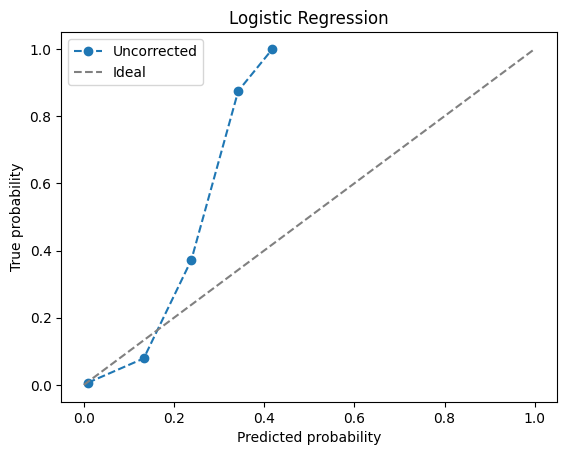

In [ ]:
# Calculate calibration curve
log_prob_true, log_prob_pred = calibration_curve(y_true, logreg_y_proba_valid[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(log_prob_pred, log_prob_true, marker='o', linestyle='--', label='Uncorrected')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Logistic Regression')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

Simple RF model

In [ ]:
classifier_RF = RandomForestClassifier()

classifier_RF.fit(X_train, y_train)

# generate class raw probabilities
rf_proba = classifier_RF.predict_proba(X_valid)

# predict class labels 0/1 for the test set
rf_predicted_train = classifier_RF.predict(X_train)
rf_predicted_valid = classifier_RF.predict(X_valid)
# generate evaluation metrics
print("confusion_matrix for training set is: ")
rf_cm_train = confusion_matrix(y_train, rf_predicted_train)
rf_cmDF_train = pd.DataFrame(rf_cm_train, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF_train)

print("confusion_matrix for validation set is: ")
rf_cm_valid = confusion_matrix(y_valid, rf_predicted_valid)
rf_cmDF_valid = pd.DataFrame(rf_cm_valid, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF_valid)

confusion_matrix for training set is: 
        pred_0  pred_1
true_0  109572       0
true_1       2    1126
confusion_matrix for validation set is: 
        pred_0  pred_1
true_0   13694       0
true_1      74      70


In [ ]:
rf_predicted_test = classifier_RF.predict(X_test)
rf_cm_test = confusion_matrix(y_test, rf_predicted_test)
rf_cmDF_test = pd.DataFrame(rf_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF_test)

        pred_0  pred_1
true_0   13695       0
true_1      68      75


In [ ]:
performance_metrics(rf_cm_train)

precision: 1.0
recall: 0.99822695035461
f1 0.9991126885536824
specificity: 1.0


(array([0.99998175, 1.        ]),
 array([1.        , 0.99822695]),
 array([0.99822695, 1.        ]),
 array([0.99999087, 0.99911269]))

In [ ]:
performance_metrics(rf_cm_valid)

precision: 1.0
recall: 0.4861111111111111
f1 0.6542056074766355
specificity: 1.0


(array([0.99462522, 1.        ]),
 array([1.        , 0.48611111]),
 array([0.48611111, 1.        ]),
 array([0.99730537, 0.65420561]))

In [ ]:
performance_metrics(rf_cm_test)

precision: 1.0
recall: 0.5244755244755245
f1 0.6880733944954128
specificity: 1.0


(array([0.99505922, 1.        ]),
 array([1.        , 0.52447552]),
 array([0.52447552, 1.        ]),
 array([0.99752349, 0.68807339]))

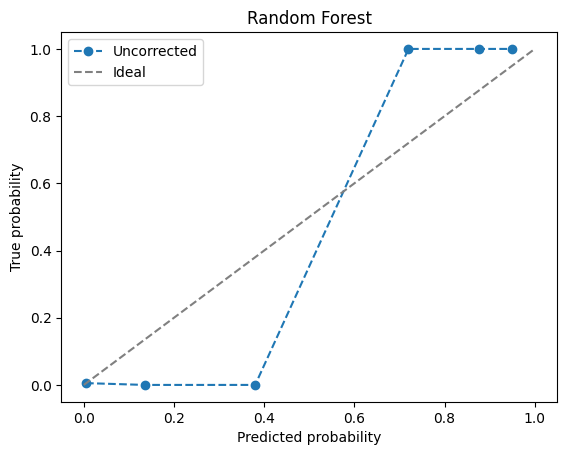

In [ ]:
# Calculate calibration curve
rf_prob_true, rf_prob_pred = calibration_curve(y_true, rf_proba[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(rf_prob_pred, rf_prob_true, marker='o', linestyle='--', label='Uncorrected')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Random Forest')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

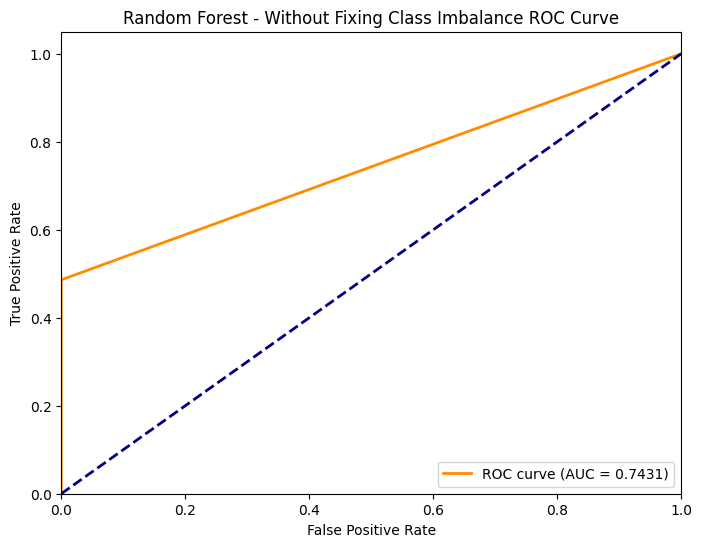

0.7430555555555556

In [ ]:
plot_roc_curve(y_true, rf_predicted_valid, "Random Forest", title = "Without Fixing Class Imbalance")

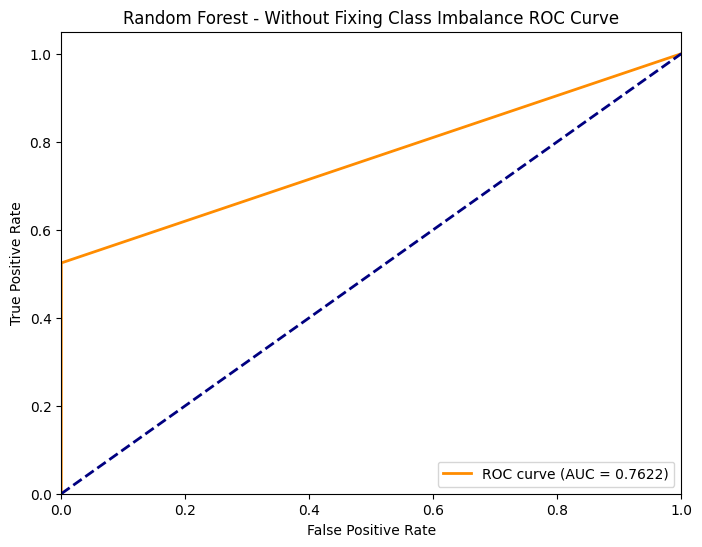

0.7622377622377623

In [ ]:
plot_roc_curve(y_test, rf_predicted_test, "Random Forest", title = "Without Fixing Class Imbalance")

#### From the simple logistic regression we can notice that the result are all predicted into non-fraud type where we suspect the performance of logistic regression was influenced by the class imbalance of the dataset

#### Accuracy here may not be a good metric to eavaluate model performance

### Address Class Imbalance

#### Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler()
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_under, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 1128]
 [   1 1128]]


In [ ]:
logreg_under = LogisticRegression()

# fit the model with data
logreg_under.fit(X_train_under,y_train_under)

# predict on test
logreg_y_under_pred = logreg_under.predict(X_valid)
logreg_y_under_proba = logreg_under.predict_proba(X_valid)

In [ ]:
logreg_cm_under = metrics.confusion_matrix(y_valid, logreg_y_under_pred)
logreg_cmDF_under = pd.DataFrame(logreg_cm_under, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logreg_cmDF_under)

        pred_0  pred_1
true_0    9548    4146
true_1      52      92


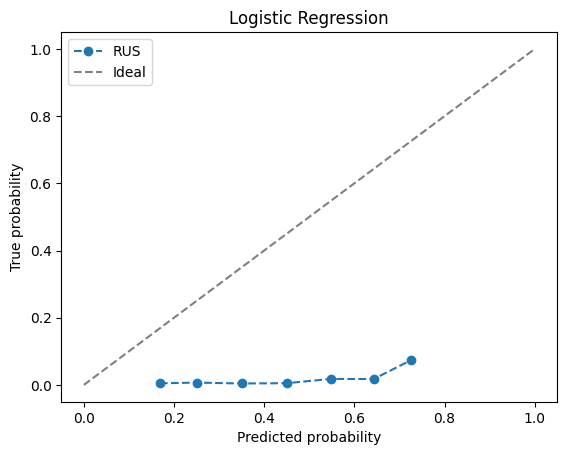

In [ ]:
# Calculate calibration curve
log_under_prob_true, log_under_prob_pred = calibration_curve(y_true, logreg_y_under_proba[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(log_under_prob_pred, log_under_prob_true, marker='o', linestyle='--', label='RUS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Logistic Regression')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

In [ ]:
performance_metrics(logreg_cm_under)

precision: 0.021708352996696555
recall: 0.6388888888888888
f1 0.04198995892286627
specificity: 0.6972396670074485


(array([0.99458333, 0.02170835]),
 array([0.69723967, 0.63888889]),
 array([0.63888889, 0.69723967]),
 array([0.81978192, 0.04198996]))

kNN

In [ ]:
knnModel_under = KNeighborsClassifier()
knnModel_under.fit(X_train_under, y_train_under)
#knn_y_pred_train = knnModel.predict(X_train)
knn_y_pred_under = knnModel_under.predict(X_valid)
knn_y_pred_under_proba = knnModel_under.predict_proba(X_valid)

In [ ]:
knn_cm_under = metrics.confusion_matrix(y_valid, knn_y_pred_under)
knn_cmDF_under = pd.DataFrame(knn_cm_under, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(knn_cmDF_under)

        pred_0  pred_1
true_0   10684    3010
true_1      56      88


In [ ]:
performance_metrics(knn_cm_under)

precision: 0.028405422853453842
recall: 0.6111111111111112
f1 0.05428747686613202
specificity: 0.7801957061486783


(array([0.99478585, 0.02840542]),
 array([0.78019571, 0.61111111]),
 array([0.61111111, 0.78019571]),
 array([0.87451911, 0.05428748]))

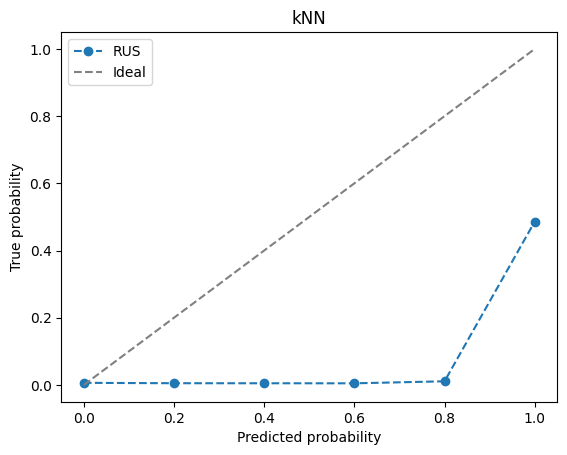

In [ ]:
# Calculate calibration curve
knn_under_prob_true, knn_under_prob_pred = calibration_curve(y_true, knn_y_pred_under_proba[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(knn_under_prob_pred, knn_under_prob_true, marker='o', linestyle='--', label='RUS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('kNN')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

Random Forest

In [ ]:
#RF on RUS training data
classifier_RF_under = RandomForestClassifier()

classifier_RF_under.fit(X_train_under, y_train_under)

# predict class labels for the test set
rf_predicted_under = classifier_RF_under.predict(X_valid)

# generate class probabilities
rf_proba_under = classifier_RF_under.predict_proba(X_valid)

# generate evaluation metrics
print ("confusion_matrix_over is: ")
rf_cm_under = confusion_matrix(y_valid, rf_predicted_under)
rf_cmDF_under = pd.DataFrame(rf_cm_under, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF_under)

performance_metrics(rf_cm_under)

confusion_matrix_over is: 
        pred_0  pred_1
true_0   13394     300
true_1      69      75
precision: 0.2
recall: 0.5208333333333334
f1 0.28901734104046245
specificity: 0.9780925952972105


(array([0.99487484, 0.2       ]),
 array([0.9780926 , 0.52083333]),
 array([0.52083333, 0.9780926 ]),
 array([0.98641234, 0.28901734]))

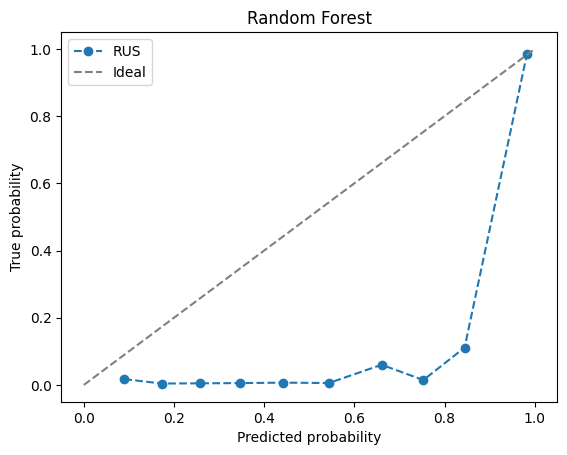

In [ ]:
# Calculate calibration curve
rf_under_prob_true, rf_under_prob_pred = calibration_curve(y_true, rf_proba_under[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(rf_under_prob_pred, rf_under_prob_true, marker='o', linestyle='--', label='RUS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Random Forest')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

XGBoost

In [ ]:
xg_class_under = xgb.XGBClassifier()
xg_class_under.fit(X_train_under,y_train_under)
xg_preds_under = xg_class_under.predict(X_valid)
xg_preds_proba_under = xg_class_under.predict_proba(X_valid)

In [ ]:
xg_cm_under= metrics.confusion_matrix(y_valid, xg_preds_under)
xg_cmDF_under = pd.DataFrame(xg_cm_under, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(xg_cmDF_under)

        pred_0  pred_1
true_0   12058    1636
true_1      63      81


In [ ]:
performance_metrics(xg_cm_under)

precision: 0.04717530576587071
recall: 0.5625
f1 0.08704997313272435
specificity: 0.8805316196874544


(array([0.99480241, 0.04717531]),
 array([0.88053162, 0.5625    ]),
 array([0.5625    , 0.88053162]),
 array([0.93418555, 0.08704997]))

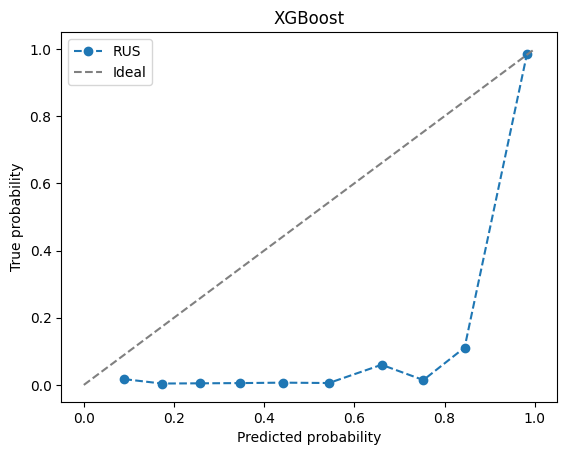

In [ ]:
# Calculate calibration curve
xg_under_prob_true, xg_under_prob_pred = calibration_curve(y_true, xg_preds_proba_under[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(rf_under_prob_pred, rf_under_prob_true, marker='o', linestyle='--', label='RUS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('XGBoost')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

####  Random Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_over, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 109572]
 [     1 109572]]


Logistic Regression

In [ ]:
logreg_over = LogisticRegression()

# fit the model with data
logreg_over.fit(X_train_over,y_train_over)

# predict on test
logreg_y_over_pred = logreg_over.predict(X_valid)
logreg_y_over_proba = logreg_over.predict_proba(X_valid)

In [ ]:
logreg_cm_over = metrics.confusion_matrix(y_valid, logreg_y_over_pred)
logreg_cmDF_over_valid = pd.DataFrame(logreg_cm_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logreg_cmDF_over_valid)

        pred_0  pred_1
true_0    9486    4208
true_1      51      93


In [ ]:
performance_metrics(logreg_cm_over)

precision: 0.021622878400372008
recall: 0.6458333333333334
f1 0.041844769403824526
specificity: 0.6927121367022053


(array([0.99465241, 0.02162288]),
 array([0.69271214, 0.64583333]),
 array([0.64583333, 0.69271214]),
 array([0.81666738, 0.04184477]))

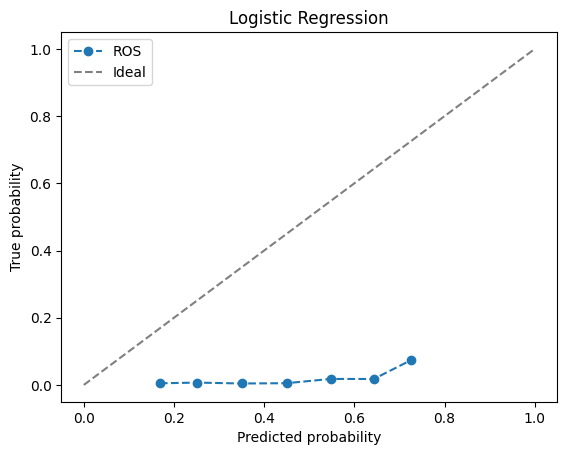

In [ ]:
# Calculate calibration curve
log_over_prob_true, log_over_prob_pred = calibration_curve(y_true, logreg_y_over_proba[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(log_under_prob_pred, log_under_prob_true, marker='o', linestyle='--', label='ROS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Logistic Regression')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

In [ ]:
knnModel_over = KNeighborsClassifier()
knnModel_over.fit(X_train_over, y_train_over)
#knn_y_pred_train = knnModel.predict(X_train)
knn_y_pred_over = knnModel_over.predict(X_valid)
knn_y_pred_over_proba = knnModel_over.predict_proba(X_valid)

In [ ]:
knn_cm_over = metrics.confusion_matrix(y_valid, knn_y_pred_over)
knn_cmDF_over = pd.DataFrame(knn_cm_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(knn_cmDF_over)

        pred_0  pred_1
true_0   13493     201
true_1      71      73


In [ ]:
performance_metrics(knn_cm_over)

precision: 0.2664233576642336
recall: 0.5069444444444444
f1 0.3492822966507177
specificity: 0.985322038849131


(array([0.99476556, 0.26642336]),
 array([0.98532204, 0.50694444]),
 array([0.50694444, 0.98532204]),
 array([0.99002128, 0.3492823 ]))

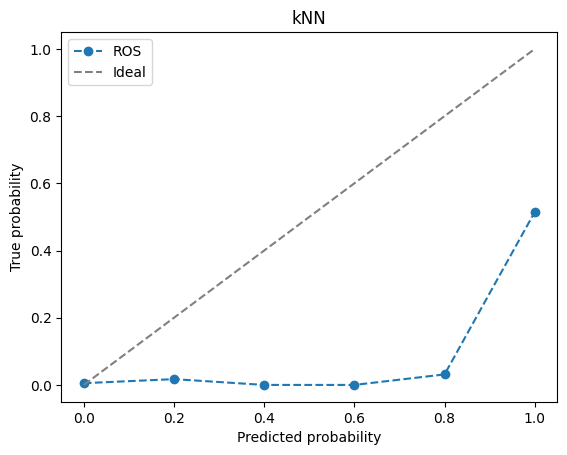

In [ ]:
# Calculate calibration curve
knn_over_prob_true, knn_over_prob_pred = calibration_curve(y_true, knn_y_pred_over_proba[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(knn_over_prob_pred, knn_over_prob_true, marker='o', linestyle='--', label='ROS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = 'grey')
ax.set_title('kNN')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

Random Forest

In [ ]:
#RF on ROS training data
classifier_RF_over = RandomForestClassifier()

classifier_RF_over.fit(X_train_over, y_train_over)

# predict class labels for the test set
rf_predicted_over = classifier_RF_over.predict(X_valid)

# generate class probabilities
rf_proba_over = classifier_RF_over.predict_proba(X_valid)

# generate evaluation metrics
print ("confusion_matrix_over is: ")
rf_cm_over = confusion_matrix(y_valid, rf_predicted_over)
rf_cmDF_over = pd.DataFrame(rf_cm_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF_over)

performance_metrics(rf_cm_over)

confusion_matrix_over is: 
        pred_0  pred_1
true_0   13694       0
true_1      74      70
precision: 1.0
recall: 0.4861111111111111
f1 0.6542056074766355
specificity: 1.0


(array([0.99462522, 1.        ]),
 array([1.        , 0.48611111]),
 array([0.48611111, 1.        ]),
 array([0.99730537, 0.65420561]))

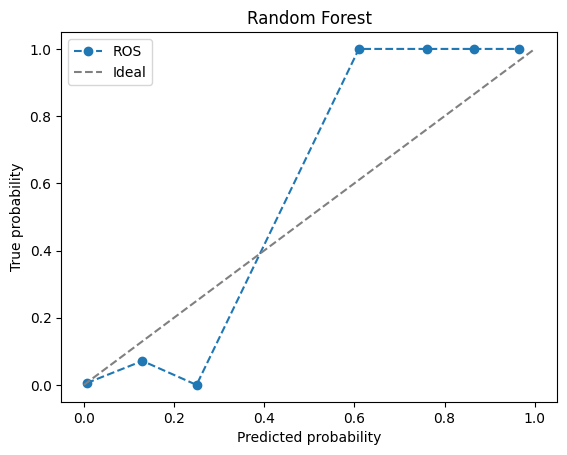

In [ ]:
# Calculate calibration curve
rf_over_prob_true, rf_over_prob_pred = calibration_curve(y_true, rf_proba_over[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(rf_over_prob_pred, rf_over_prob_true, marker='o', linestyle='--', label='ROS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Random Forest')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

XGBoost

In [ ]:
xg_class_over = xgb.XGBClassifier()
xg_class_over.fit(X_train_over, y_train_over)
xg_preds_over = xg_class_over.predict(X_valid)
xg_preds_proba_over = xg_class_over.predict_proba(X_valid)

In [ ]:
xg_cm_over= metrics.confusion_matrix(y_valid, xg_preds_over)
xg_cmDF_over = pd.DataFrame(xg_cm_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(xg_cmDF_over)

        pred_0  pred_1
true_0   13656      38
true_1      71      73


In [ ]:
performance_metrics(xg_cm_over)

precision: 0.6576576576576577
recall: 0.5069444444444444
f1 0.5725490196078431
specificity: 0.9972250620709799


(array([0.99482771, 0.65765766]),
 array([0.99722506, 0.50694444]),
 array([0.50694444, 0.99722506]),
 array([0.99602494, 0.57254902]))

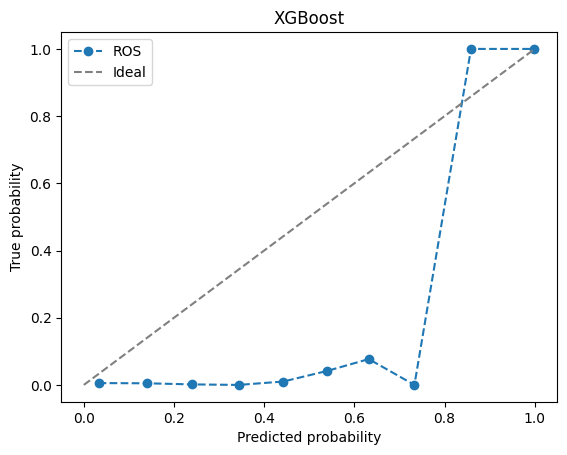

In [ ]:
# Calculate calibration curve
xg_over_prob_true, xg_over_prob_pred = calibration_curve(y_true, xg_preds_proba_over[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(xg_over_prob_pred, xg_over_prob_true, marker='o', linestyle='--', label='ROS')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('XGBoost')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

#### SMOTE sampling

In [ ]:
#Wrong way to sampling: smote before split train/test, then test data does not reflect true distribution in reality,
#and “blend” information from the test set into the training of the model. overfit! think about the case of simple
#oversampling (where I just duplicate observations). If I upsample a dataset before splitting it into a train and
#validation set, I could end up with the same observation in both datasets

#https://imbalanced-learn.org/en/stable/install.html

# Install
# imbalanced-learn is currently available on the PyPi’s reporitories and you can install it via pip:

# pip install -U imbalanced-learn

#oversampling on only the training data, the right way!
#sampling_strategy = number of samples in the majority class over the number of samples in the minority class after resampling

smote = SMOTE()
x_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 109572]
 [     1 109572]]


Logistic Regerssion

In [ ]:
# instantiate the model (using the default parameters)
logreg_sm = LogisticRegression()

# fit the model with data
logreg_sm.fit(x_train_sm,y_train_sm)

# predict on test
logreg_sm_y_pred = logreg_sm.predict(X_valid)
logreg_sm_y_proba = logreg_sm.predict_proba(X_valid)

In [ ]:
logit_cm_sm = metrics.confusion_matrix(y_valid, logreg_sm_y_pred)
logit_cmDF_sm = pd.DataFrame(logit_cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(logit_cmDF_sm)

        pred_0  pred_1
true_0    9458    4236
true_1      51      93


In [ ]:
performance_metrics(logit_cm_sm)

precision: 0.021483021483021482
recall: 0.6458333333333334
f1 0.041582830315224674
specificity: 0.6906674455966116


(array([0.99463666, 0.02148302]),
 array([0.69066745, 0.64583333]),
 array([0.64583333, 0.69066745]),
 array([0.81523941, 0.04158283]))

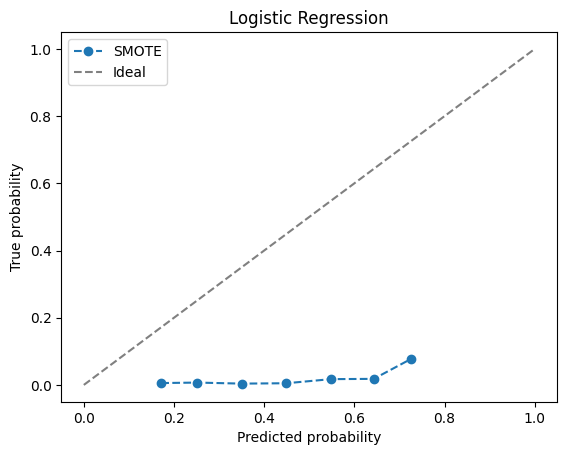

In [ ]:
log_sm_prob_true, log_sm_prob_pred = calibration_curve(y_true, logreg_sm_y_proba[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(log_sm_prob_pred, log_sm_prob_true, marker='o', linestyle='--', label='SMOTE')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = 'grey')
ax.set_title("Logistic Regression")
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

In [ ]:
knnModel = KNeighborsClassifier()
knnModel.fit(x_train_sm, y_train_sm)
#knn_y_pred_train = knnModel.predict(X_train)
knn_y_pred_valid_sm = knnModel.predict(X_valid)
knn_y_proba_valid_sm = knnModel.predict_proba(X_valid)

In [ ]:
knn_cm_valid_sm = metrics.confusion_matrix(y_valid, knn_y_pred_valid_sm)
knn_cmDF_valid_sm = pd.DataFrame(knn_cm_valid_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(knn_cmDF_valid_sm)

        pred_0  pred_1
true_0   12503    1191
true_1      64      80


In [ ]:
performance_metrics(knn_cm_valid_sm)

precision: 0.06294256490952006
recall: 0.5555555555555556
f1 0.11307420494699645
specificity: 0.9130276033299255


(array([0.9949073 , 0.06294256]),
 array([0.9130276 , 0.55555556]),
 array([0.55555556, 0.9130276 ]),
 array([0.9522105, 0.1130742]))

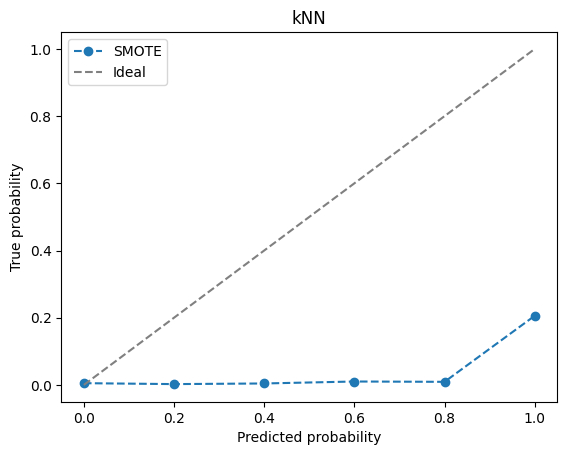

In [ ]:
knn_sm_prob_true, knn_sm_prob_pred = calibration_curve(y_true, knn_y_proba_valid_sm[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(knn_sm_prob_pred, knn_sm_prob_true, marker='o', linestyle='--', label='SMOTE')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = 'grey')
ax.set_title("kNN")
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

Random Forest

In [ ]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier()

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
rf_predicted_sm = classifier_RF_sm.predict(X_valid)

# generate class probabilities
rf_proba_sm = classifier_RF_sm.predict_proba(X_valid)

# generate evaluation metrics
print ("confusion_matrix_sm is: ")
rf_cm_sm = confusion_matrix(y_test, rf_predicted_sm)
rf_cmDF_sm = pd.DataFrame(rf_cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(rf_cmDF_sm)

performance_metrics(rf_cm_sm)


confusion_matrix_sm is: 
        pred_0  pred_1
true_0   13626      69
true_1     143       0
precision: 0.0
recall: 0.0
f1 nan
specificity: 0.9949616648411829


(array([0.98961435, 0.        ]),
 array([0.99496166, 0.        ]),
 array([0.        , 0.99496166]),
 array([0.9922808,       nan]))

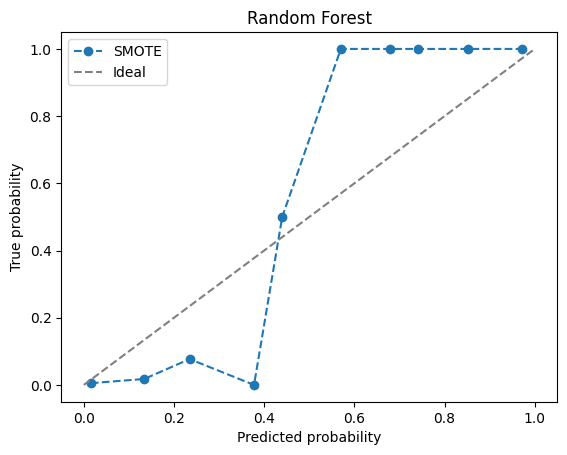

In [ ]:
# Calculate calibration curve
rf_sm_prob_true, rf_sm_prob_pred = calibration_curve(y_true, rf_proba_sm[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(rf_sm_prob_pred, rf_sm_prob_true, marker='o', linestyle='--', label='SMOTE')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('Random Forest')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

XGBoost

In [ ]:
xg_class_sm = xgb.XGBClassifier()
xg_class_sm.fit(x_train_sm, y_train_sm)
xg_preds_sm = xg_class_sm.predict(X_valid)
xg_preds_proba_sm = xg_class_sm.predict_proba(X_valid)

In [ ]:
xg_cm_sm = metrics.confusion_matrix(y_valid, xg_preds_sm)
xg_cmDF_sm = pd.DataFrame(xg_cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(xg_cmDF_sm)

        pred_0  pred_1
true_0   12623    1071
true_1      70      74


In [ ]:
performance_metrics(xg_cm_sm)

precision: 0.06462882096069869
recall: 0.5138888888888888
f1 0.1148176881303336
specificity: 0.9217905652110413


(array([0.99448515, 0.06462882]),
 array([0.92179057, 0.51388889]),
 array([0.51388889, 0.92179057]),
 array([0.95675901, 0.11481769]))

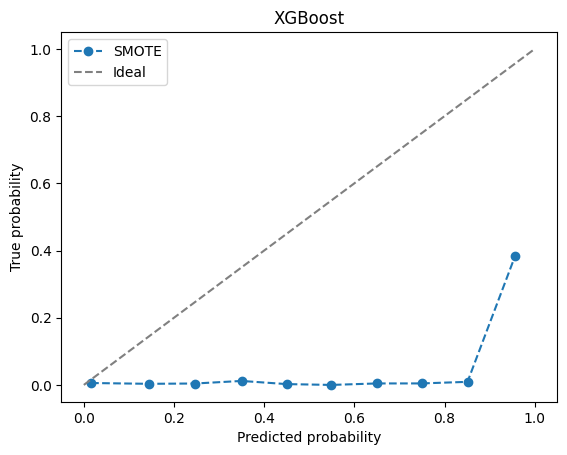

In [ ]:
# Calculate calibration curve
xg_sm_prob_true, xg_sm_prob_pred = calibration_curve(y_true, xg_preds_proba_sm[:,1], n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots()
ax.plot(xg_sm_prob_pred, xg_sm_prob_true, marker='o', linestyle='--', label='SMOTE')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal', color = "grey")
ax.set_title('XGBoost')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

ACCURACY SCORE CALCULATION

Uncorrected

In [ ]:
logreg_accuracy_uncorrect = accuracy_score(y_valid, logreg_y_pred_valid)
knn_accuracy_uncorrect = accuracy_score(y_valid, knn_y_pred_valid)
rf_accuracy_uncorrect = accuracy_score(y_valid, rf_predicted_valid)
xg_acuracy_uncorrect = accuracy_score(y_valid, xg_preds_valid)
print("Accuracy score without correct class imbalance for logistic regression: ", logreg_accuracy_uncorrect)
print("Accuracy score without correct class imbalance for kNN: ", knn_accuracy_uncorrect)
print("Accuracy score without correct class imbalance for random forest: ", rf_accuracy_uncorrect)
print("Accuracy score without correct class imbalance for XGBoost: ", xg_acuracy_uncorrect)

Accuracy score without correct class imbalance for logistic regression:  0.9895938719468131
Accuracy score without correct class imbalance for kNN:  0.994435612082671
Accuracy score without correct class imbalance for random forest:  0.9946524064171123
Accuracy score without correct class imbalance for XGBoost:  0.9946524064171123


Random Under Sampling

In [ ]:
logreg_accuracy_under = accuracy_score(y_valid, logreg_y_under_pred)
knn_accuracy_under = accuracy_score(y_valid, knn_y_pred_under)
rf_accuracy_under = accuracy_score(y_valid, rf_predicted_under)
xg_acuracy_under = accuracy_score(y_valid, xg_preds_under)
print("Accuracy score after RUS for logistic regression: ", logreg_accuracy_under)
print("Accuracy score after RUS for kNN: ", knn_accuracy_under)
print("Accuracy score after RUS for random forest: ", rf_accuracy_under)
print("Accuracy score after RUS for XGBoost: ", xg_acuracy_under)

Accuracy score after RUS for logistic regression:  0.6966324613383437
Accuracy score after RUS for kNN:  0.778436190200896
Accuracy score after RUS for random forest:  0.9733342968637086
Accuracy score after RUS for XGBoost:  0.8772221419280243


Random Over Sampling

In [ ]:
logreg_accuracy_over = accuracy_score(y_valid, logreg_y_over_pred)
knn_accuracy_over = accuracy_score(y_valid, knn_y_pred_over)
rf_accuracy_over = accuracy_score(y_valid, rf_predicted_over)
xg_acuracy_over = accuracy_score(y_valid, xg_preds_over)
print("Accuracy score after ROS for logistic regression: ", logreg_accuracy_over)
print("Accuracy score after ROS for kNN: ", knn_accuracy_over)
print("Accuracy score after ROS for random forest: ", rf_accuracy_over)
print("Accuracy score after ROS for XGBoost: ", xg_acuracy_over)

Accuracy score after ROS for logistic regression:  0.6922243098713687
Accuracy score after ROS for kNN:  0.9803439803439803
Accuracy score after ROS for random forest:  0.9946524064171123
Accuracy score after ROS for XGBoost:  0.9921231391819627


SMOTE

In [ ]:
logreg_accuracy_sm = accuracy_score(y_valid, logreg_sm_y_pred)
knn_accuracy_sm = accuracy_score(y_valid, knn_y_pred_valid_sm)
rf_accuracy_sm = accuracy_score(y_valid, rf_predicted_sm)
xg_acuracy_sm = accuracy_score(y_valid, xg_preds_sm)
print("Accuracy score after SMOTE for logistic regression: ", logreg_accuracy_sm)
print("Accuracy score after SMOTE for kNN: ", knn_accuracy_sm)
print("Accuracy score after SMOTE for random forest: ", rf_accuracy_sm)
print("Accuracy score after SMOTE for XGBoost: ", xg_acuracy_sm)

Accuracy score after SMOTE for logistic regression:  0.690200896083249
Accuracy score after SMOTE for kNN:  0.9093077034253505
Accuracy score after SMOTE for random forest:  0.9945801416389651
Accuracy score after SMOTE for XGBoost:  0.9175458881341234


### Calibration Intercept Calculation

In [ ]:
from scipy.stats import t
def calculate_calibration_intercept_ci(prob_true, prob_pred, threshold=0.5, alpha=0.05):
    # Convert probabilities to binary labels using a threshold
    y_true = np.where(prob_true >= threshold, 1, 0)

    # Check if only one class is present in the data
    unique_classes = np.unique(y_true)
    if len(unique_classes) == 1:
        print("Error: Only one class present in the data.")
        return None, None

    # Fit logistic regression model with offset
    reg = LogisticRegression(solver='liblinear', max_iter=1000)
    reg.fit(prob_pred.reshape(-1, 1), y_true)

    # Extract calibration intercept
    calibration_intercept = reg.intercept_[0]

    # Calculate variance
    n_samples = len(y_true)
    y_pred = reg.predict_proba(prob_pred.reshape(-1, 1))[:, 1]
    variance = np.mean(np.abs(y_pred - prob_true)) / n_samples

    # Calculate standard error
    se_intercept = np.sqrt(variance)

    # Calculate confidence interval
    dof = n_samples - 2  # degrees of freedom
    t_critical = t.ppf(1 - alpha / 2, dof)
    ci_lower = calibration_intercept - t_critical * se_intercept
    ci_upper = calibration_intercept + t_critical * se_intercept

    return calibration_intercept, (ci_lower, ci_upper)

Uncorrected

In [ ]:
logit_calibrate_prob_true = log_prob_true
logit_calibrate_prob_pred = log_prob_pred
logit_calibration_intercept, logit_ci = calculate_calibration_intercept_ci(logit_calibrate_prob_true, logit_calibrate_prob_pred)

print("Calibration intercept for Uncorrected Logistic Regression:", logit_calibration_intercept)
print("95% Confidence Interval of the intercept:", logit_ci)

Calibration intercept for Uncorrected Logistic Regression: -0.25308756071214267
95% Confidence Interval of the intercept: (-1.1145621239504697, 0.6083870025261845)


In [ ]:
knn_calibrate_prob_true = knn_prob_true
knn_calibrate_prob_pred = knn_prob_pred
knn_calibration_intercept, knn_ci = calculate_calibration_intercept_ci(knn_calibrate_prob_true, knn_calibrate_prob_pred)

print("Calibration intercept for Uncorrected kNN:", knn_calibration_intercept)
print("95% Confidence Interval of the intercept:", knn_ci)

Calibration intercept for Uncorrected kNN: -0.3636994643748914
95% Confidence Interval of the intercept: (-1.2463373632433874, 0.5189384344936044)


In [ ]:
rf_calibrate_prob_true = rf_prob_true
rf_calibrate_prob_pred = rf_prob_pred
rf_calibration_intercept, rf_ci = calculate_calibration_intercept_ci(rf_calibrate_prob_true, rf_calibrate_prob_pred)

print("Calibration intercept for Uncorrected Random Forest:", rf_calibration_intercept)
print("95% Confidence Interval of the intercept:", rf_ci)

Calibration intercept for Uncorrected Random Forest: -0.22845695338786137
95% Confidence Interval of the intercept: (-0.9773528252433239, 0.5204389184676013)


In [ ]:
xg_calibrate_prob_true = xg_prob_true
xg_calibrate_prob_pred = xg_prob_pred
xg_calibration_intercept, xg_ci = calculate_calibration_intercept_ci(xg_calibrate_prob_true, xg_calibrate_prob_pred)

print("Calibration intercept for Uncorrected XGBoost:", xg_calibration_intercept)
print("95% Confidence Interval of the intercept:", xg_ci)

Calibration intercept for Uncorrected XGBoost: -0.7454311300879192
95% Confidence Interval of the intercept: (-1.5508947387602081, 0.060032478584369886)


RUS

In [ ]:
logit_calibrate_prob_true_under = log_under_prob_true
logit_calibrate_prob_pred_under = log_under_prob_pred
logit_calibration_intercept_under, logit_ci_under = calculate_calibration_intercept_ci(logit_calibrate_prob_true_under, logit_calibrate_prob_pred_under)

print("Calibration intercept for RUS Logistic Regression:", logit_calibration_intercept_under)
print("95% Confidence Interval of the intercept:", logit_ci_under)

Error: Only one class present in the data.
Calibration intercept for RUS Logistic Regression: None
95% Confidence Interval of the intercept: None


In [ ]:
knn_calibrate_prob_true_under = knn_under_prob_true
knn_calibrate_prob_pred_under = knn_under_prob_pred
knn_calibration_intercept_under, knn_ci_under = calculate_calibration_intercept_ci(knn_calibrate_prob_true_under, knn_calibrate_prob_pred_under)

print("Calibration intercept for RUS kNN:", knn_calibration_intercept_under)
print("95% Confidence Interval of the intercept:", knn_ci_under)

Error: Only one class present in the data.
Calibration intercept for RUS kNN: None
95% Confidence Interval of the intercept: None


In [ ]:
rf_calibrate_prob_true_under = rf_under_prob_true
rf_calibrate_prob_pred_under = rf_under_prob_pred
rf_calibration_intercept_under, rf_ci_under = calculate_calibration_intercept_ci(rf_calibrate_prob_true_under, rf_calibrate_prob_pred_under)

print("Calibration intercept for Uncorrected Random Forest:", rf_calibration_intercept_under)
print("95% Confidence Interval of the intercept:", rf_ci_under)

Calibration intercept for Uncorrected Random Forest: -1.2024322898840678
95% Confidence Interval of the intercept: (-1.5697808911223028, -0.8350836886458327)


In [ ]:
xg_calibrate_prob_true_under = xg_under_prob_true
xg_calibrate_prob_pred_under = xg_under_prob_pred
xg_calibration_intercept_under, xg_ci_under = calculate_calibration_intercept_ci(xg_calibrate_prob_true_under, xg_calibrate_prob_pred_under)

print("Calibration intercept for Uncorrected XGBoost:", xg_calibration_intercept_under)
print("95% Confidence Interval of the intercept:", xg_ci_under)

Error: Only one class present in the data.
Calibration intercept for Uncorrected XGBoost: None
95% Confidence Interval of the intercept: None


ROS

In [ ]:
logit_calibrate_prob_true_over = log_over_prob_true
logit_calibrate_prob_pred_over = log_over_prob_pred
logit_calibration_intercept_over, logit_ci_over = calculate_calibration_intercept_ci(logit_calibrate_prob_true_over, logit_calibrate_prob_pred_over)

print("Calibration intercept for ROS Logistic Regression:", logit_calibration_intercept_over)
print("95% Confidence Interval of the intercept:", logit_ci_over)

Error: Only one class present in the data.
Calibration intercept for ROS Logistic Regression: None
95% Confidence Interval of the intercept: None


In [ ]:
knn_calibrate_prob_true_over = knn_over_prob_true
knn_calibrate_prob_pred_over = knn_over_prob_pred
knn_calibration_intercept_over, knn_ci_iver = calculate_calibration_intercept_ci(knn_calibrate_prob_true_over, knn_calibrate_prob_pred_over)

print("Calibration intercept for Uncorrected kNN:", knn_calibration_intercept)
print("95% Confidence Interval of the intercept:", knn_ci)

Calibration intercept for Uncorrected kNN: -0.3636994643748914
95% Confidence Interval of the intercept: (-1.2463373632433874, 0.5189384344936044)


In [ ]:
rf_calibrate_prob_true_over = rf_over_prob_true
rf_calibrate_prob_pred_over = rf_over_prob_pred
rf_calibration_intercept_over, rf_ci_over = calculate_calibration_intercept_ci(rf_calibrate_prob_true_over, rf_calibrate_prob_pred_over)

print("Calibration intercept for Uncorrected Random Forest:", rf_calibration_intercept_over)
print("95% Confidence Interval of the intercept:", rf_ci_over)

Calibration intercept for Uncorrected Random Forest: -0.10607182897049225
95% Confidence Interval of the intercept: (-0.7241762226092185, 0.512032564668234)


In [ ]:
xg_calibrate_prob_true_over = xg_over_prob_true
xg_calibrate_prob_pred_over = xg_over_prob_pred
xg_calibration_intercept_over, xg_ci_over = calculate_calibration_intercept_ci(xg_calibrate_prob_true_over, xg_calibrate_prob_pred_over)

print("Calibration intercept for Uncorrected XGBoost:", xg_calibration_intercept_over)
print("95% Confidence Interval of the intercept:", xg_ci_over)

Calibration intercept for Uncorrected XGBoost: -1.00206755776062
95% Confidence Interval of the intercept: (-1.436313866593437, -0.567821248927803)


SMOTE

In [ ]:
logit_calibrate_prob_true_sm = log_sm_prob_true
logit_calibrate_prob_pred_sm = log_sm_prob_pred
logit_calibration_intercept_sm, logit_ci_sm = calculate_calibration_intercept_ci(logit_calibrate_prob_true_sm, logit_calibrate_prob_pred_sm)

print("Calibration intercept for Uncorrected Logistic Regression:", logit_calibration_intercept_sm)
print("95% Confidence Interval of the intercept:", logit_ci_sm)

Error: Only one class present in the data.
Calibration intercept for Uncorrected Logistic Regression: None
95% Confidence Interval of the intercept: None


In [ ]:
knn_calibrate_prob_true_sm = knn_sm_prob_true
knn_calibrate_prob_pred_sm = knn_sm_prob_pred
knn_calibration_intercept_sm, knn_ci_sm = calculate_calibration_intercept_ci(knn_calibrate_prob_true_sm, knn_calibrate_prob_pred_sm)

print("Calibration intercept for Uncorrected kNN:", knn_calibration_intercept_sm)
print("95% Confidence Interval of the intercept:", knn_ci_sm)

Error: Only one class present in the data.
Calibration intercept for Uncorrected kNN: None
95% Confidence Interval of the intercept: None


In [ ]:
rf_calibrate_prob_true_sm = rf_sm_prob_true
rf_calibrate_prob_pred_sm = rf_sm_prob_pred
rf_calibration_intercept_sm, rf_ci_sm = calculate_calibration_intercept_ci(rf_calibrate_prob_true_sm, rf_calibrate_prob_pred_sm)

print("Calibration intercept for Uncorrected Random Forest:", rf_calibration_intercept_sm)
print("95% Confidence Interval of the intercept:", rf_ci_sm)

Calibration intercept for Uncorrected Random Forest: -0.06172038679576376
95% Confidence Interval of the intercept: (-0.5101843663269499, 0.38674359273542236)


In [ ]:
xg_calibrate_prob_true_sm = xg_sm_prob_true
xg_calibrate_prob_pred_sm = xg_sm_prob_pred
xg_calibration_intercept_sm, xg_ci_sm = calculate_calibration_intercept_ci(xg_calibrate_prob_true_sm, xg_calibrate_prob_pred_sm)

print("Calibration intercept for Uncorrected XGBoost:", xg_calibration_intercept_sm)
print("95% Confidence Interval of the intercept:", xg_ci_sm)

Error: Only one class present in the data.
Calibration intercept for Uncorrected XGBoost: None
95% Confidence Interval of the intercept: None


# Part 6: Parameter tuning by GridSearchCV

Eval metrics for GridSearchCV over all fits upon combination of parameters and cv

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1),
    'roc_auc_score': make_scorer(roc_auc_score)
}

def grid_search_wrapper(model, parameters, refitscore):
    """
    Fits a GridSearchCV classifier optimizing for F1 score while considering sensitivity and specificity.
    Prints classifier performance metrics.
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit= refitscore,
                               cv=5, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Make the predictions
    y_pred = grid_search.predict(X_valid)
    y_prob = grid_search.predict_proba(X_valid)[:, 1]

    print('Best params for', 'refitscore:')
    print(grid_search.best_params_)

    # Confusion matrix on the test data
    print('\nConfusion matrix of {} optimized for', refitscore, 'on the test data:'.format(model.__class__.__name__))
    cm = confusion_matrix(y_valid, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)

    print("\t%s: %r" % ("ROC AUC Score is: ", roc_auc_score(y_valid, y_prob)))
    print("\t%s: %r" % ("F1 Score is: ", f1_score(y_valid, y_pred)))

    sensitivity = float(cm[1, 1]) / (cm[1, 0] + cm[1, 1])
    specificity = float(cm[0, 0]) / (cm[0, 0] + cm[0, 1])
    print('Sensitivity (Recall) =', sensitivity)
    print('Specificity =', specificity)

    return grid_search


Optimizing on f1_score on LR

In [ ]:
# C: inverse of regularization strength, smaller values specify stronger regularization
LRGrid = {"C" : np.logspace(-2,2,5), "penalty":["l1"]}# l1 lasso l2 ridge
#param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
logRegModel = LogisticRegression(random_state=0, solver='liblinear')

grid_search_LR_f1 = grid_search_wrapper(logRegModel, LRGrid, 'f1_score')

Best params for refitscore:
{'C': 0.1, 'penalty': 'l1'}

Confusion matrix of {} optimized for f1_score on the test data:
        pred_0  pred_1
true_0   13693       1
true_1     142       2
	ROC AUC Score is: : 0.7720093349885595
	F1 Score is: : 0.0272108843537415
Sensitivity (Recall) = 0.013888888888888888
Specificity = 0.9999269753176574


In [ ]:
# C: inverse of regularization strength, smaller values specify stronger regularization
#LRGrid = {"C" : np.logspace(-2,2,5), "penalty":["l1"]}# l1 lasso l2 ridge
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
logRegModel = LogisticRegression(random_state=0, solver='liblinear')

grid_search_LR_f1 = grid_search_wrapper(logRegModel, param_grid, 'f1_score')

Best params for refitscore:
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of {} optimized for f1_score on the test data:
        pred_0  pred_1
true_0   13694       0
true_1     144       0
	ROC AUC Score is: : 0.7193849090437012
	F1 Score is: : 0.0
Sensitivity (Recall) = 0.0
Specificity = 1.0


Optimizing on f1_score on kNN

In [ ]:
knn_grid_model = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1,11)}
knn_grid_search = grid_search_wrapper(knn_grid_model, knn_params, 'f1_score')

Best params for refitscore:
{'n_neighbors': 4}

Confusion matrix of {} optimized for f1_score on the test data:
        pred_0  pred_1
true_0   13692       2
true_1      74      70
	ROC AUC Score is: : 0.748553959154861
	F1 Score is: : 0.6481481481481481
Sensitivity (Recall) = 0.4861111111111111
Specificity = 0.9998539506353147


Optimizing on f1_score on RF

In [ ]:
rf_parameters = {
    'max_depth': [None, 5, 15],
    'n_estimators': [10, 30, 50, 100],
    'class_weight': [{0: 1, 1: w} for w in [0.2, 1, 10]],
}

clf = RandomForestClassifier(random_state=0)

In [ ]:
grid_search_rf_f1 = grid_search_wrapper(clf, rf_parameters, 'f1_score')

Best params for F1 Score:
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 30}

Confusion matrix of RandomForestClassifier optimized for F1 Score on the test data:
        pred_0  pred_1
true_0   13694       0
true_1      74      70
	ROC AUC Score is: : 0.7367556553559548
	F1 Score is: : 0.6542056074766355
Sensitivity (Recall) = 0.4861111111111111
Specificity = 1.0


In [ ]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_

In [ ]:
print(best_rf_model_f1)

RandomForestClassifier(class_weight={0: 1, 1: 0.2}, n_estimators=30,
                       random_state=0)


Optimizing on F1 socre on XGBoost

In [ ]:
xgb_parameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
}

xgb_grid_model = xgb.XGBClassifier(random_state=0)
xgb_grid_search = grid_search_wrapper(xgb_grid_model, xgb_parameters, 'f1_score')

Best params for refitscore:
{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}

Confusion matrix of {} optimized for f1_score on the test data:
        pred_0  pred_1
true_0   13694       0
true_1      74      70
	ROC AUC Score is: : 0.7553870916703178
	F1 Score is: : 0.6542056074766355
Sensitivity (Recall) = 0.4861111111111111
Specificity = 1.0


Four Models by optimizing Recall(Sensitivity)

L1 regularization

In [ ]:
grid_search_LR_recall_lasso = grid_search_wrapper(logRegModel, LRGrid, 'recall_score')

Best params for refitscore:
{'C': 1.0, 'penalty': 'l1'}

Confusion matrix of {} optimized for recall_score on the test data:
        pred_0  pred_1
true_0   13693       1
true_1     142       2
	ROC AUC Score is: : 0.7689255635071321
	F1 Score is: : 0.0272108843537415
Sensitivity (Recall) = 0.013888888888888888
Specificity = 0.9999269753176574


In [ ]:
best_logit_model_recall_lasso = grid_search_LR_recall_lasso.best_estimator_

In [ ]:
best_logit_y_pred = best_logit_model_recall_lasso.predict(X_valid)
best_logit_cm = confusion_matrix(y_valid, best_logit_y_pred)
best_logit_cmDF = pd.DataFrame(best_logit_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_logit_cmDF)

        pred_0  pred_1
true_0   13693       1
true_1     142       2


In [ ]:
performance_metrics(best_logit_cm)

precision: 0.6666666666666666
recall: 0.013888888888888888
f1 0.0272108843537415
specificity: 0.9999269753176574


(array([0.98973618, 0.66666667]),
 array([0.99992698, 0.01388889]),
 array([0.01388889, 0.99992698]),
 array([0.99480548, 0.02721088]))

In [ ]:
best_logit_y_pred_test = best_logit_model_recall_lasso.predict(X_test)
best_logit_cm_test = confusion_matrix(y_test, best_logit_y_pred_test)
best_logit_cmDF_test = pd.DataFrame(best_logit_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_logit_cmDF_test)

        pred_0  pred_1
true_0   13695       0
true_1     143       0


In [ ]:
performance_metrics(best_logit_cm_test)

precision: nan
recall: 0.0
f1 nan
specificity: 1.0


(array([0.98966614,        nan]),
 array([1., 0.]),
 array([0., 1.]),
 array([0.99480623,        nan]))

L2 regularization

In [ ]:
grid_search_LR_recall_ridge = grid_search_wrapper(logRegModel, param_grid, 'recall_score')

Best params for refitscore:
{'C': 0.01, 'penalty': 'l2'}

Confusion matrix of {} optimized for recall_score on the test data:
        pred_0  pred_1
true_0   13694       0
true_1     144       0
	ROC AUC Score is: : 0.7193849090437012
	F1 Score is: : 0.0
Sensitivity (Recall) = 0.0
Specificity = 1.0


In [ ]:
best_logit_model_recall_ridge = grid_search_LR_recall_ridge.best_estimator_

In [ ]:
best_logit2_y_pred = best_logit_model_recall_ridge.predict(X_valid)
best_logit2_cm = confusion_matrix(y_valid, best_logit2_y_pred)
best_logit2_cmDF = pd.DataFrame(best_logit2_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_logit2_cmDF)

        pred_0  pred_1
true_0   13694       0
true_1     144       0


In [ ]:
best_logit2_y_pred_test = best_logit_model_recall_ridge.predict(X_test)
best_logit2_cm_test = confusion_matrix(y_test, best_logit2_y_pred_test)
best_logit2_cmDF_test = pd.DataFrame(best_logit2_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_logit2_cmDF_test)

        pred_0  pred_1
true_0   13694       0
true_1     144       0


In [ ]:
performance_metrics(best_logit2_cm)

precision: nan
recall: 0.0
f1 nan
specificity: 1.0


(array([0.98959387,        nan]),
 array([1., 0.]),
 array([0., 1.]),
 array([0.99476972,        nan]))

In [ ]:
performance_metrics(best_logit2_cm_test)

precision: nan
recall: 0.0
f1 nan
specificity: 1.0


(array([0.98966614,        nan]),
 array([1., 0.]),
 array([0., 1.]),
 array([0.99480623,        nan]))

In [ ]:
knn_grid_search_recall = grid_search_wrapper(knn_grid_model, knn_params, 'recall_score')

Best params for refitscore:
{'n_neighbors': 1}

Confusion matrix of {} optimized for recall_score on the test data:
        pred_0  pred_1
true_0   13627      67
true_1      73      71
	ROC AUC Score is: : 0.7440814509192997
	F1 Score is: : 0.5035460992907802
Sensitivity (Recall) = 0.4930555555555556
Specificity = 0.9951073462830436


In [ ]:
best_knn_model_recall = knn_grid_search_recall.best_estimator_

In [ ]:
best_knn_y_pred = best_knn_model_recall.predict(X_valid)
best_knn_cm = confusion_matrix(y_valid, best_knn_y_pred)
best_knn_cmDF = pd.DataFrame(best_knn_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_knn_cmDF)

        pred_0  pred_1
true_0   13627      67
true_1      73      71


In [ ]:
performance_metrics(best_knn_cm)

precision: 0.5144927536231884
recall: 0.4930555555555556
f1 0.5035460992907802
specificity: 0.9951073462830436


(array([0.99467153, 0.51449275]),
 array([0.99510735, 0.49305556]),
 array([0.49305556, 0.99510735]),
 array([0.99488939, 0.5035461 ]))

In [ ]:
best_knn_y_pred_test = best_knn_model_recall.predict(X_test)
best_knn_cm_test = confusion_matrix(y_test, best_knn_y_pred_test)
best_knn_cmDF_test = pd.DataFrame(best_knn_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_knn_cmDF_test)

        pred_0  pred_1
true_0   13625      70
true_1      68      75


In [ ]:
performance_metrics(best_knn_cm_test)

precision: 0.5172413793103449
recall: 0.5244755244755245
f1 0.5208333333333334
specificity: 0.9948886454910552


(array([0.99503396, 0.51724138]),
 array([0.99488865, 0.52447552]),
 array([0.52447552, 0.99488865]),
 array([0.9949613 , 0.52083333]))

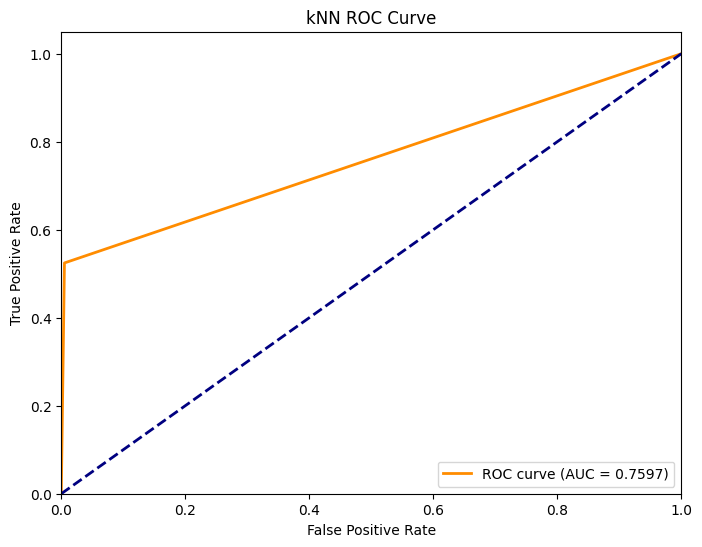

0.7596820849832898

In [ ]:
plot_roc_curve(y_test, best_knn_y_pred_test, "kNN", title = "")

In [ ]:
grid_search_rf_recall = grid_search_wrapper(clf, rf_parameters, 'recall_score')

Best params for refitscore:
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 30}

Confusion matrix of {} optimized for recall_score on the test data:
        pred_0  pred_1
true_0   13694       0
true_1      74      70
	ROC AUC Score is: : 0.7367556553559548
	F1 Score is: : 0.6542056074766355
Sensitivity (Recall) = 0.4861111111111111
Specificity = 1.0


In [ ]:
best_rf_model_recall = grid_search_rf_recall.best_estimator_

In [ ]:
best_rf_predicted = best_rf_model_recall .predict(X_valid)
best_rf_cm = confusion_matrix(y_valid, best_rf_predicted)
best_rf_cmDF = pd.DataFrame(best_rf_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_rf_cmDF)

        pred_0  pred_1
true_0   13694       0
true_1      74      70


In [ ]:
best_rf_predicted_test = best_rf_model_recall.predict(X_test)
best_rf_cm_test = confusion_matrix(y_test, best_rf_predicted_test)
best_rf_cmDF_test = pd.DataFrame(best_rf_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_rf_cmDF_test)

        pred_0  pred_1
true_0   13695       0
true_1      68      75


In [ ]:
performance_metrics(best_rf_cm)

precision: 1.0
recall: 0.4861111111111111
f1 0.6542056074766355
specificity: 1.0


(array([0.99462522, 1.        ]),
 array([1.        , 0.48611111]),
 array([0.48611111, 1.        ]),
 array([0.99730537, 0.65420561]))

In [ ]:
performance_metrics(best_rf_cm_test)

precision: 1.0
recall: 0.5244755244755245
f1 0.6880733944954128
specificity: 1.0


(array([0.99505922, 1.        ]),
 array([1.        , 0.52447552]),
 array([0.52447552, 1.        ]),
 array([0.99752349, 0.68807339]))

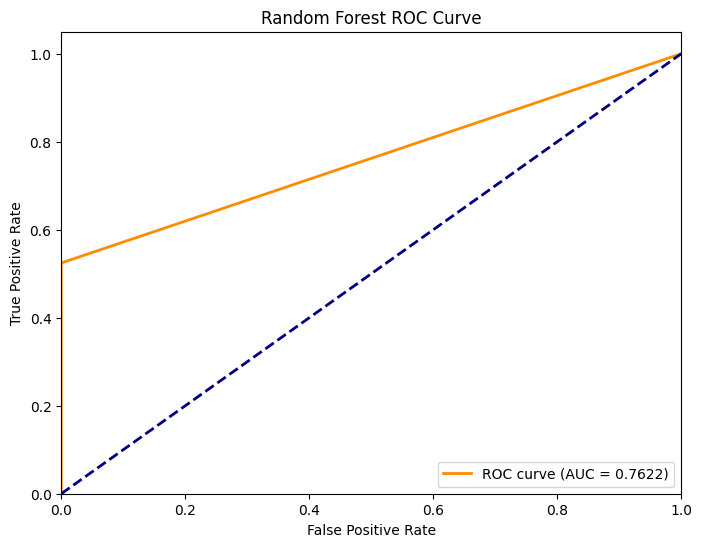

0.7622377622377623

In [ ]:
plot_roc_curve(y_test, best_rf_predicted_test, "Random Forest", title = "")

In [ ]:
xgb_grid_search_recall = grid_search_wrapper(xgb_grid_model, xgb_parameters, 'recall_score')

Best params for refitscore:
{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}

Confusion matrix of {} optimized for recall_score on the test data:
        pred_0  pred_1
true_0   13694       0
true_1      74      70
	ROC AUC Score is: : 0.7553870916703178
	F1 Score is: : 0.6542056074766355
Sensitivity (Recall) = 0.4861111111111111
Specificity = 1.0


In [ ]:
best_xg_model_recall = xgb_grid_search_recall.best_estimator_

In [ ]:
best_xg_predicted = best_xg_model_recall.predict(X_valid)
best_xg_cm = confusion_matrix(y_valid, best_xg_predicted)
best_xg_cmDF = pd.DataFrame(best_xg_cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_xg_cmDF)

        pred_0  pred_1
true_0   13694       0
true_1      74      70


In [ ]:
best_xg_predicted_test = best_rf_model_recall.predict(X_test)
best_xg_cm_test = confusion_matrix(y_test, best_xg_predicted_test)
best_xg_cmDF_test = pd.DataFrame(best_xg_cm_test, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(best_xg_cmDF_test)

        pred_0  pred_1
true_0   13695       0
true_1      68      75


In [ ]:
performance_metrics(best_xg_cm)

precision: 1.0
recall: 0.4861111111111111
f1 0.6542056074766355
specificity: 1.0


(array([0.99462522, 1.        ]),
 array([1.        , 0.48611111]),
 array([0.48611111, 1.        ]),
 array([0.99730537, 0.65420561]))

In [ ]:
performance_metrics(best_xg_cm_test)

precision: 1.0
recall: 0.5244755244755245
f1 0.6880733944954128
specificity: 1.0


(array([0.99505922, 1.        ]),
 array([1.        , 0.52447552]),
 array([0.52447552, 1.        ]),
 array([0.99752349, 0.68807339]))

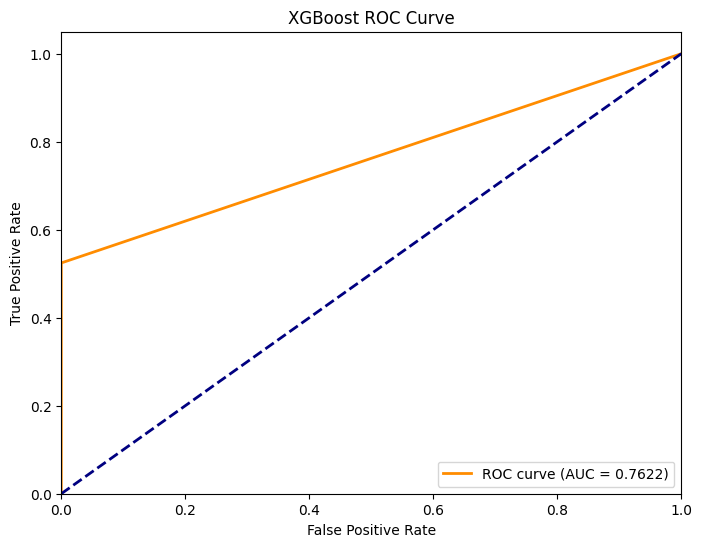

0.7622377622377623

In [ ]:
plot_roc_curve(y_test, best_xg_predicted_test, "XGBoost", title = "")

Print the best model after cross validation and grid search

In [ ]:
#Var Importance
pd.DataFrame(best_rf_model_recall.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

importance
interval_after_signup      0.462680
purchase_days_of_year      0.106477
purchase_seconds_of_day    0.077336
signup_seconds_of_day      0.075270
signup_days_of_year        0.059122
purchase_value             0.045510
n_dev_shared               0.040418
age                        0.037109
n_country_shared           0.028003
n_ip_shared                0.023020
sex                        0.009046
source_Ads                 0.006127
browser_Chrome             0.005303
source_SEO                 0.005251
source_Direct              0.005231
browser_IE                 0.004434
browser_Safari             0.004208
browser_FireFox            0.004073
browser_Opera              0.001383

In [ ]:
pd.DataFrame(best_xg_model_recall.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

importance
interval_after_signup      0.995960
n_dev_shared               0.004027
purchase_seconds_of_day    0.000012
purchase_value             0.000000
browser_Chrome             0.000000
n_ip_shared                0.000000
browser_Safari             0.000000
browser_Opera              0.000000
browser_IE                 0.000000
browser_FireFox            0.000000
source_Direct              0.000000
source_SEO                 0.000000
sex                        0.000000
source_Ads                 0.000000
purchase_days_of_year      0.000000
signup_seconds_of_day      0.000000
signup_days_of_year        0.000000
age                        0.000000
n_country_shared           0.000000